# Initialization

In [1]:
#Import all the UTILITY functions
from UTILITY_quickstart import *

#Look at the signature and documentation for initializeTao()
?initializeTao

Signature:
initializeTao(
    filePath=None,
    runSetLatticeTF=True,
    setLatticeDefaultsFile=None,
    numMacroParticles=None,
    runImpactTF=False,
    inputBeamFilePathSuffix=None,
    scratchPath=None,
    randomizeFileNames=False,
    csrTF=False,
    transverseWakes=False,
    **kwargs,
)
Docstring:
Initialize a Tao simulation instance.

Parameters
----------
filePath : str, optional
    Path to the FACET-II lattice files. Defaults to the current working directory.

runSetLatticeTF : bool
    Whether or not to run setLattice(). If False, the unmodified lattice specified by tao.init is loaded
setLatticeDefaultsFile : str
    Path to the file which setLattice() loads. If not specified uses defaults.yml

numMacroparticles : int
    The number of macroparticles to simulate
runImpactTF : bool
    Whether or not to run IMPACT-T to generate an initial beam
inputBeamFilePathSuffix : str
    Relative path from filePath to a file containing an intial beam

scratchPath : str
    Path t

In [2]:
#Initialize tao object for single-particle tracking only
tao = initializeTao()

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-S2E
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using /Users/nmajik/Documents/SLAC/FACET2-S2E/setLattice_configs/defaults.yml
WARNING! No beam file is specified!
Number of macro particles defined by input file
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-S2E/beams/activeBeamFile.h5, and reinit to tao


# Single-particle results

In [3]:
# Ensure that the lattice matches the design at standard treaty point, PR10571
launchTwissCorrection(tao)

No evalElement provided. Assuming golden lattice PR10571
Optimization Results:
Optimal Parameters: [0.13755483 0.95354498 0.40561992 2.20428422]
Objective Function Value at Optimal Parameters: 1.5713461387770165e-09
Number of Iterations: 93
Converged: True


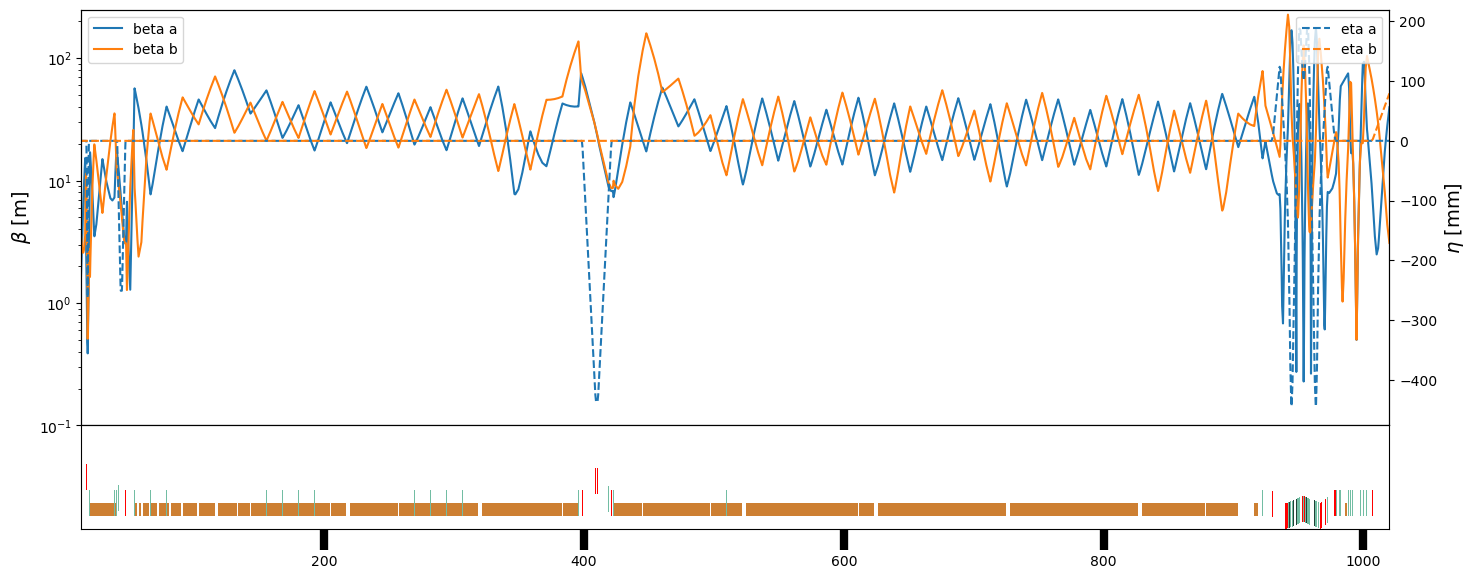

In [4]:
# Plot the beta functions and dispersion throughout the whole linac
floorplanPlot(tao)

In [5]:
# Get the Twiss parameters at a particular element
tao.ele_twiss("PENT")

{'mode_flip': False,
 'beta_a': 0.499382808054094,
 'alpha_a': 0.0310420410146822,
 'gamma_a': 2.00440141744313,
 'phi_a': 73.0934669708683,
 'eta_a': -5.54002627203796e-06,
 'etap_a': -1.05997356796689e-05,
 'beta_b': 0.500632473929507,
 'alpha_b': -0.0164048278497085,
 'gamma_b': 1.99801085719746,
 'phi_b': 60.4949499141395,
 'eta_b': -2.11805920050045e-18,
 'etap_b': -2.52222176160021e-18,
 'eta_x': -5.54002627203796e-06,
 'etap_x': -1.05997356796689e-05,
 'eta_y': -2.11784425998279e-18,
 'etap_y': -2.52067060637746e-18}

In [6]:
# Calculate a transport matrix between elements
getMatrix(tao, "PENT", "DTOTR", print = True);

-3.924442,-2.027473,-0.000000,0.000000,0.000000,-0.000000
-0.326665,-0.423577,-0.000000,0.000000,0.000000,-0.000000
-0.000000,0.000000,-1.854894,1.930395,0.000000,0.055920
-0.000000,0.000000,-0.136005,-0.397574,0.000000,0.006000
0.000000,0.000000,0.003524,-0.033815,1.000000,-0.000006
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


# Multi-particle tracking

In [7]:
#Load a reference configuration
importedDefaultSettings = loadConfig("setLattice_configs/2024-10-22_oneBunch_baseline3.yml")


#Initialize tao object
tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    numMacroParticles = 1e4,
    csrTF = False 
        # CSR is usually enabled since it can significantly impact the beam 
        # It's computationally expensive to calculate though
        # Turned off here just to make the demo notebook faster
)

#Set lattice to the loaded config
setLattice(tao, **importedDefaultSettings)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-S2E
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using /Users/nmajik/Documents/SLAC/FACET2-S2E/setLattice_configs/defaults.yml
Number of macro particles = 10000.0
Beam created, written to /Users/nmajik/Documents/SLAC/FACET2-S2E/beams/activeBeamFile.h5, and reinit to tao


In [8]:
#Track the beam from start to end
trackBeam(tao, **importedDefaultSettings)

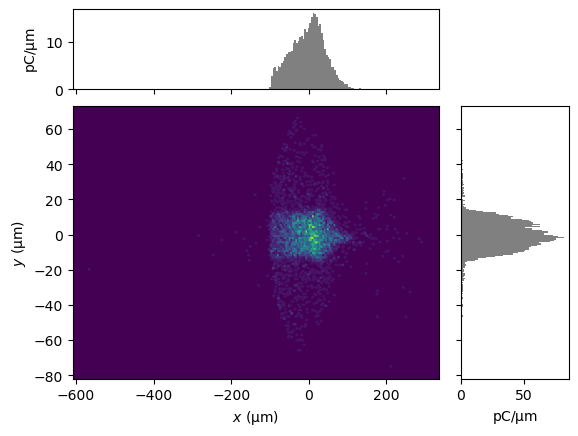

ParticleGroup with 9997 particles with total charge 1.5995200000000007e-09 C


In [9]:
#Get the beam at element "PENT"
P =  getBeamAtElement(tao, "PENT")

#Plot the x-y projection of the beam at that location
display(plotMod(P, 'x', 'y',  bins=200));
plt.clf()

print(P)

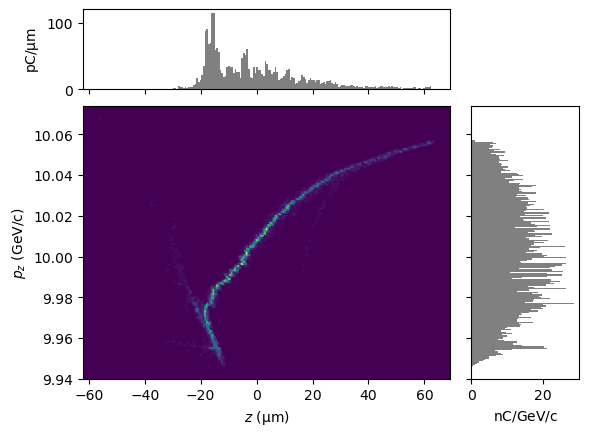

In [10]:
#Plot the longitudinal phase space
display(plotMod(P, 'z', 'pz',  bins=200));

## Changing linac phase

In [11]:
# Look at the L2 phase in the present configuration
importedDefaultSettings["L2PhaseSet"]

-39.0717691285

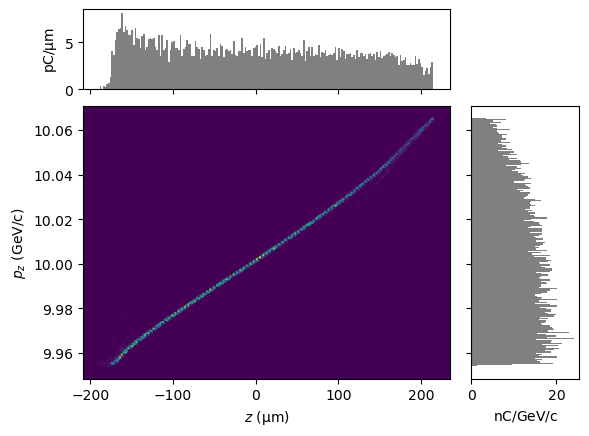

In [12]:
#Change the phase of L2 to -30 degrees, then update the gradient to maintain same energy gain
setLinacPhase(tao, "L2", -30)
setLinacGradientAuto(tao, "L2", 4.165e9)

#Retrack the beam
trackBeam(tao, **importedDefaultSettings)

#Plot the new longitudinal phase space
P =  getBeamAtElement(tao, "PENT")
display(plotMod(P, 'z', 'pz',  bins=200));

## Demonstrating partial tracking

In [13]:
# Sometimes it's only necessary to track a subset of the beamline
# We'll grab the beam from the last simulation at MFFF then make it the "activeBeamFile"
trackStart = "MFFF"
P = getBeamAtElement(tao, trackStart)
makeBeamActiveBeamFile( P, tao = tao ) 

#Then, it is possible to track from that element
trackBeam(
    tao,
    trackStart = trackStart,
    trackEnd = "DTOTR",
    **importedDefaultSettings 
) 

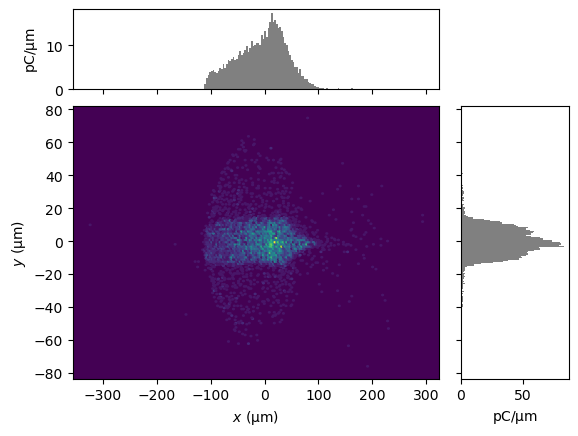

In [14]:
# Check the spot at PENT (which is between trackStart and trackEnd)
P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'x', 'y',  bins=200));



In [15]:
#Look at the strength of a final focus quad, Q4FF
#getQuadkG() will return the integrated gradient in kG; these are the same units used by the control system
getQuadkG(tao, "Q4FF")

-81.25125099285313

In [16]:
#Change that quad setting to -40 kG
setQuadkG(tao, "Q0FF", -40.0)

#Track the beam through a subset of the now-modified lattice
trackBeam(
    tao,
    trackStart = trackStart,
    trackEnd = "DTOTR",
    **importedDefaultSettings 
) 

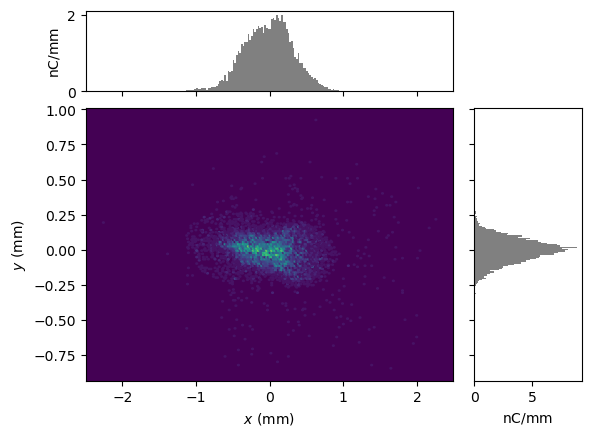

In [17]:
# Look at the new profile
P = getBeamAtElement(tao, "PENT")
display(plotMod(P, 'x', 'y',  bins=200));